In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from prophet import Prophet  # if this errors, install 'prophet' in your env

PROJECT_ROOT = Path(r"C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting")

OUTPUT_DIR = PROJECT_ROOT / "output" / "clean"
IMAGES_DIR = PROJECT_ROOT / "images" / "atl"
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

print("OUTPUT_DIR:", OUTPUT_DIR)
print("IMAGES_DIR:", IMAGES_DIR)


Importing plotly failed. Interactive plots will not work.


OUTPUT_DIR: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean
IMAGES_DIR: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\atl


In [2]:
atl_path = OUTPUT_DIR / "delta_atl.csv"
print("Loading:", atl_path)

df_atl = pd.read_csv(atl_path)
df_atl.columns = [c.lower() for c in df_atl.columns]

df_atl["date"] = pd.to_datetime(df_atl["date"])

# total passengers = domestic + international
df_atl["pax"] = df_atl["passengers_domestic"] + df_atl["passengers_international"]

df_atl = df_atl.sort_values("date").reset_index(drop=True)
df_atl[["date", "pax"]].head()


Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_atl.csv


,date,pax
0,2002-10-01,2297618.0
1,2002-11-01,2165850.0
2,2002-12-01,2343481.0
3,2003-01-01,2050000.0
4,2003-02-01,1919940.0


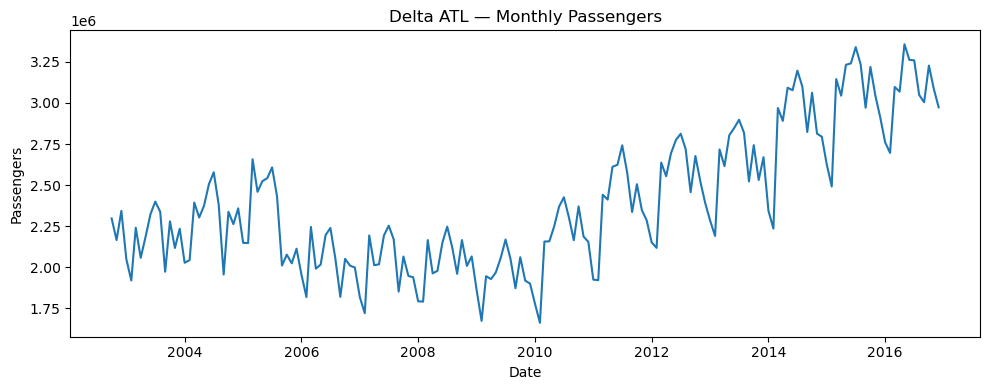

In [3]:
plt.figure(figsize=(10,4))
plt.plot(df_atl["date"], df_atl["pax"])
plt.title("Delta ATL — Monthly Passengers")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.tight_layout()
plt.show()


In [4]:
df_prophet = df_atl[["date", "pax"]].rename(columns={"date": "ds", "pax": "y"})

print(df_prophet.head())
print(df_prophet["ds"].min(), "→", df_prophet["ds"].max())
print("Number of months:", len(df_prophet))


          ds          y
0 2002-10-01  2297618.0
1 2002-11-01  2165850.0
2 2002-12-01  2343481.0
3 2003-01-01  2050000.0
4 2003-02-01  1919940.0
2002-10-01 00:00:00 → 2017-03-01 00:00:00
Number of months: 174


In [5]:
# choose 24-month test window
test_horizon_months = 24

df_prophet = df_prophet.sort_values("ds")
split_point = len(df_prophet) - test_horizon_months

train_df = df_prophet.iloc[:split_point].copy()
test_df  = df_prophet.iloc[split_point:].copy()

print("Train period:", train_df["ds"].min().date(), "→", train_df["ds"].max().date(), "| n =", len(train_df))
print("Test period :", test_df["ds"].min().date(),  "→", test_df["ds"].max().date(),  "| n =", len(test_df))


Train period: 2002-10-01 → 2015-03-01 | n = 150
Test period : 2015-04-01 → 2017-03-01 | n = 24


In [6]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

m.fit(train_df)

# forecast over the entire period (train + test)
future = m.make_future_dataframe(periods=test_horizon_months, freq="MS")
forecast = m.predict(future)

# merge forecast with actuals
df_merged = df_prophet.merge(forecast[["ds", "yhat"]], on="ds", how="left")

# extract test portion for metrics
test_merged = df_merged.iloc[split_point:].copy()
y_true = test_merged["y"].values
y_pred = test_merged["yhat"].values

mae  = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
mape = np.mean(np.abs(y_true - y_pred) / y_true) * 100

print(f"ATL backtest metrics (last {test_horizon_months} months):")
print(f"  MAE : {mae:,.0f}")
print(f"  RMSE: {rmse:,.0f}")
print(f"  MAPE: {mape:,.2f}%")


13:10:38 - cmdstanpy - INFO - Chain [1] start processing
13:10:38 - cmdstanpy - INFO - Chain [1] done processing


ATL backtest metrics (last 24 months):
  MAE : nan
  RMSE: nan
  MAPE: nan%


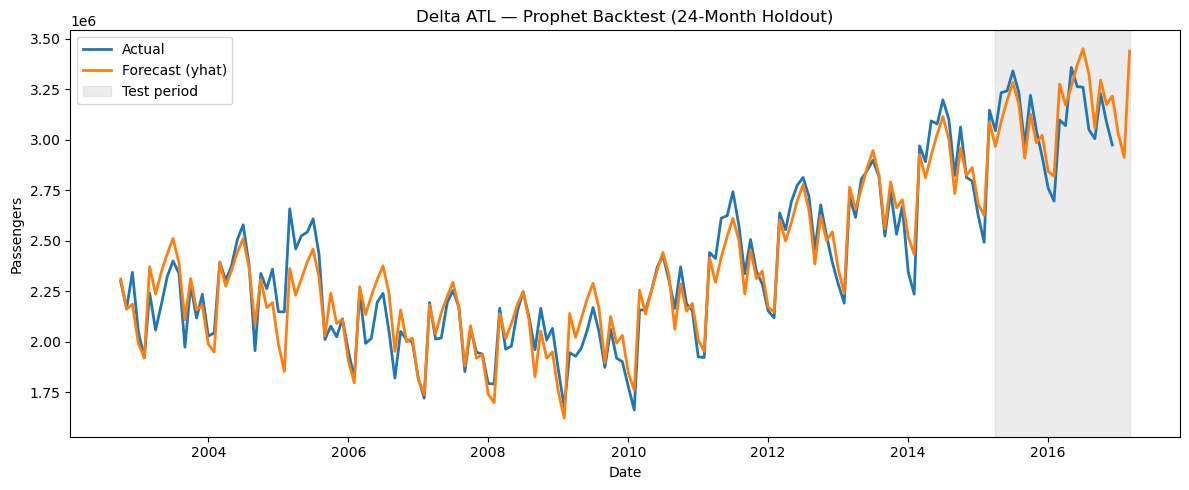

Saved: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\atl\atl_passengers_backtest.png


In [7]:
plt.figure(figsize=(12,5))

plt.plot(df_merged["ds"], df_merged["y"], label="Actual", linewidth=2)
plt.plot(df_merged["ds"], df_merged["yhat"], label="Forecast (yhat)", linewidth=2)

# highlight test region
plt.axvspan(test_df["ds"].min(), test_df["ds"].max(), color="grey", alpha=0.15, label="Test period")

plt.title("Delta ATL — Prophet Backtest (24-Month Holdout)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.tight_layout()

out_path = IMAGES_DIR / "atl_passengers_backtest.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


In [8]:
# Refit on full ATL data
m_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
m_full.fit(df_prophet)

# Forecast 36 months into the future
future_full = m_full.make_future_dataframe(periods=36, freq="MS")
forecast_full = m_full.predict(future_full)

forecast_full.tail()


13:11:22 - cmdstanpy - INFO - Chain [1] start processing
13:11:22 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
202,2019-08-01,3.646197e+06,3.631799e+06,3.926101e+06,3.574989e+06,3.714150e+06,139726.941606,139726.941606,139726.941606,139726.941606,139726.941606,139726.941606,0.0,0.0,0.0,3.785924e+06
203,2019-09-01,3.659671e+06,3.359012e+06,3.656156e+06,3.584987e+06,3.731685e+06,-149437.115108,-149437.115108,-149437.115108,-149437.115108,-149437.115108,-149437.115108,0.0,0.0,0.0,3.510234e+06
204,2019-10-01,3.672711e+06,3.582006e+06,3.877708e+06,3.594968e+06,3.749647e+06,63832.360711,63832.360711,63832.360711,63832.360711,63832.360711,63832.360711,0.0,0.0,0.0,3.736543e+06
205,2019-11-01,3.686185e+06,3.440985e+06,3.747845e+06,3.605712e+06,3.768777e+06,-91188.359286,-91188.359286,-91188.359286,-91188.359286,-91188.359286,-91188.359286,0.0,0.0,0.0,3.594996e+06
206,2019-12-01,3.699224e+06,3.455128e+06,3.778522e+06,3.615387e+06,3.784489e+06,-83874.252007,-83874.252007,-83874.252007,-83874.252007,-83874.252007,-83874.252007,0.0,0.0,0.0,3.615350e+06


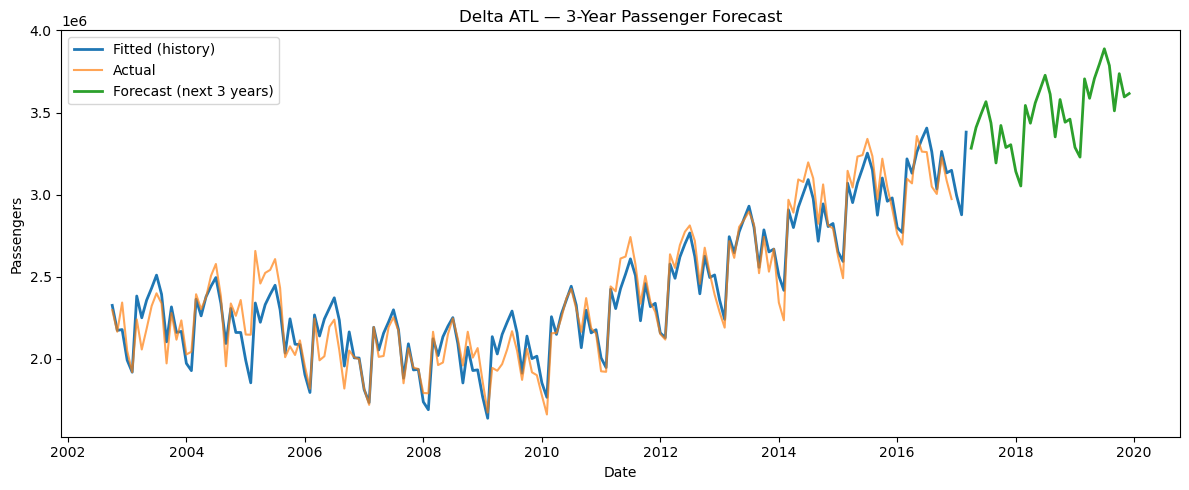

Saved: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\atl\atl_passengers_3year_forecast.png


In [9]:
plt.figure(figsize=(12,5))

hist = forecast_full[forecast_full["ds"] <= df_prophet["ds"].max()]
future = forecast_full[forecast_full["ds"] > df_prophet["ds"].max()]

plt.plot(hist["ds"], hist["yhat"], label="Fitted (history)", linewidth=2)
plt.plot(df_prophet["ds"], df_prophet["y"], label="Actual", linewidth=1.5, alpha=0.7)
plt.plot(future["ds"], future["yhat"], label="Forecast (next 3 years)", linewidth=2)

plt.title("Delta ATL — 3-Year Passenger Forecast")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.tight_layout()

out_path = IMAGES_DIR / "atl_passengers_3year_forecast.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


c:\Users\Seb\anaconda3\envs\aviation\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Seb\anaconda3\envs\aviation\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Seb\anaconda3\envs\aviation\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. 

Saved: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\atl\atl_passengers_components.png


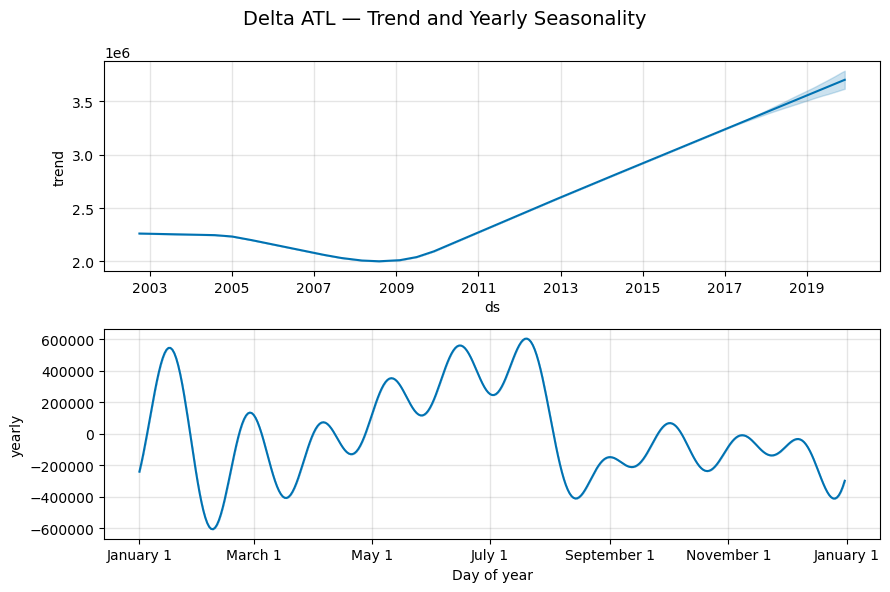

In [10]:
fig = m_full.plot_components(forecast_full)
fig.suptitle("Delta ATL — Trend and Yearly Seasonality", fontsize=14)
plt.tight_layout()

out_path = IMAGES_DIR / "atl_passengers_components.png"
fig.savefig(out_path, dpi=300)
print("Saved:", out_path)
